In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import binary_f1_score
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device = 'cpu'

In [4]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [5]:
def stratified_under_sample(group: pd.DataFrame, k: int, random_state: int):
    global category_size
    # shuffle data
    group = group.sample(frac=1, random_state=random_state)
    
    # making a dictionary for checking if all the groups are equally insert into the array
    unique_categories = set(group)
    
    # getting the size of each category per fold
    folded_category = category_size // k
    
    # storing temporary data
    test_res = []
    train_res = []

    for i in range(k):
        test_indexes = []
        train_indexes = []
        
        # for each iteration of the outer loop we need to reset dict
        count_type = {category: 0 for category in unique_categories}
        
        for category in unique_categories:
            # making a window of data to retreive
            if (category == 'Background') | (category == 'Benign'):
                start = (folded_category * 2) * i
                stop = (folded_category * 2) * (i + 1)
            else:
                start = folded_category * i
                stop = folded_category * (i + 1)
            test_indexes.extend(group[group == category].iloc[start:stop].index)
        
        for x in group.index:
            if x not in test_indexes:
                train_indexes.append(x)
                
        # shuffling the data with the same seed in order to have the same result in both the dataset
        np.random.shuffle(test_indexes)
        test_res.append(test_indexes)
        np.random.shuffle(train_indexes)
        train_res.append(train_indexes)
        
    return test_res, train_res

In [6]:
# how need to initialize a nn.relu each time you use it
class MLP(nn.Module):
    def __init__(self, n_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(n_features, 6), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(3, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
def mlp_train(X_train, y_train, verbose, epochs):
    # Initialize the model
    model = MLP(X_train.shape[1]).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if type(X_train) == pd.core.frame.DataFrame:
        X_train = X_train.to_numpy()
    
    # Convert data to PyTorch tensors (assuming X_train and y_train are numpy arrays)
    X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
    y_train_tensor = torch.from_numpy(y_train.to_numpy()).to(device)

  

    # Train the model
    epochs = epochs
    batch_size = 200
    
    start_train = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # Optionally, print the loss at each epoch
        if verbose:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

    end_train = time.time()
    print("execution time: ", end_train - start_train)
        
    return model

In [8]:
def cross_validation(X, y, group, verbose, epochs):
    test_kfold, train_kfold = stratified_under_sample(group, 10, 12)
    '''
    if type(X) == pd.core.frame.DataFrame:
        X = X.to_numpy()
    '''
    cvscores = []

    start_cv = time.time()
    for test, train in zip(test_kfold, train_kfold):
        X_train = scaler.transform(X.loc[train])
        X_test = scaler.transform(X.loc[test])
        
        # rimuovere validation a ogni turno
        model = mlp_train(X_train, y[train], False, epochs)
        
        with torch.no_grad():
            model.eval()
            X_test_tensor = torch.from_numpy(X_test.astype(np.float32)).to(device)
            y_predicted = (model(X_test_tensor) >= 0.5).squeeze().cpu()
            
            cvscores.append(metrics.f1_score(y[test], y_predicted))
    end_cv = time.time()    
    
    return np.mean(cvscores), np.std(cvscores), end_cv - start_cv

In [9]:
dtype_dict = {
    'Unnamed: 0': 'uint32',
    'uid': 'str',
    'originh': 'category',
    'originp': 'uint16',
    'responh': 'category',
    'responp': 'uint16',
    'flow_duration': 'float64',
    'fwd_pkts_tot': 'uint64',
    'bwd_pkts_tot': 'uint64',
    'fwd_data_pkts_tot': 'uint64',
    'bwd_data_pkts_tot': 'uint64',
    'fwd_pkts_per_sec': 'float64',
    'bwd_pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'down_up_ratio': 'float32',
    'fwd_header_size_tot': 'uint64',
    'fwd_header_size_min': 'uint8',
    'fwd_header_size_max': 'uint8',
    'bwd_header_size_tot': 'uint64',
    'bwd_header_size_min': 'uint8',
    'bwd_header_size_max': 'uint8',
    'flow_FIN_flag_count': 'uint64',
    'flow_SYN_flag_count': 'uint64',
    'flow_RST_flag_count': 'uint64',
    'fwd_PSH_flag_count': 'uint64',
    'bwd_PSH_flag_count': 'uint64',
    'flow_ACK_flag_count': 'uint64',
    'fwd_URG_flag_count': 'uint64',
    'bwd_URG_flag_count': 'uint64',
    'flow_CWR_flag_count': 'uint64',
    'flow_ECE_flag_count': 'uint64',
    'fwd_pkts_payload.min': 'uint16',
    'fwd_pkts_payload.max': 'uint16',
    'fwd_pkts_payload.tot': 'float64',
    'fwd_pkts_payload.avg': 'float64',
    'fwd_pkts_payload.std': 'float64',
    'bwd_pkts_payload.min': 'uint16',
    'bwd_pkts_payload.max': 'uint16',
    'bwd_pkts_payload.tot': 'float64',
    'bwd_pkts_payload.avg': 'float64',
    'bwd_pkts_payload.std': 'float64',
    'flow_pkts_payload.min': 'uint16',
    'flow_pkts_payload.max': 'uint16',
    'flow_pkts_payload.tot': 'float64',
    'flow_pkts_payload.avg': 'float64',
    'flow_pkts_payload.std': 'float64',
    'fwd_iat.min': 'float64',
    'fwd_iat.max': 'float64',
    'fwd_iat.tot': 'float64',
    'fwd_iat.avg': 'float64',
    'fwd_iat.std': 'float64',
    'bwd_iat.min': 'float64',
    'bwd_iat.max': 'float64',
    'bwd_iat.tot': 'float64',
    'bwd_iat.avg': 'float64',
    'bwd_iat.std': 'float64',
    'flow_iat.min': 'float64',
    'flow_iat.max': 'float64',
    'flow_iat.tot': 'float64',
    'flow_iat.avg': 'float64',
    'flow_iat.std': 'float64',
    'payload_bytes_per_second': 'float64',
    'fwd_subflow_pkts': 'float64',
    'bwd_subflow_pkts': 'float64',
    'fwd_subflow_bytes': 'float64',
    'bwd_subflow_bytes': 'float64',
    'fwd_bulk_bytes': 'float64',
    'bwd_bulk_bytes': 'float64',
    'fwd_bulk_packets': 'float32',
    'bwd_bulk_packets': 'float32',
    'fwd_bulk_rate': 'float64',
    'bwd_bulk_rate': 'float64',
    'active.min': 'float64',
    'active.max': 'float64',
    'active.tot': 'float64',
    'active.avg': 'float64',
    'active.std': 'float64',
    'idle.min': 'float64',
    'idle.max': 'float64',
    'idle.tot': 'float64',
    'idle.avg': 'float64',
    'idle.std': 'float64',
    'fwd_init_window_size': 'uint16',
    'bwd_init_window_size': 'uint16',
    'fwd_last_window_size': 'uint16',
    'traffic_category': 'category',
    'Label': 'bool'
}

selected_features = [
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size", "traffic_category", "Label"
]

In [10]:
ds = pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [11]:
with open('mlp_data/model.pickle', 'rb') as handle:
    model = pickle.load(handle)
    
with open('mlp_data/deep_shap_exp.pickle', 'rb') as handle:
    exp = pickle.load(handle)

In [12]:
category_size = 3279
sampling_weights = {'Background': category_size * 2, 'Benign': category_size * 2, 'XMRIGCC CryptoMiner': category_size, 'Probing': category_size, 'Bruteforce': category_size, 'Bruteforce-XML': category_size}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [13]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

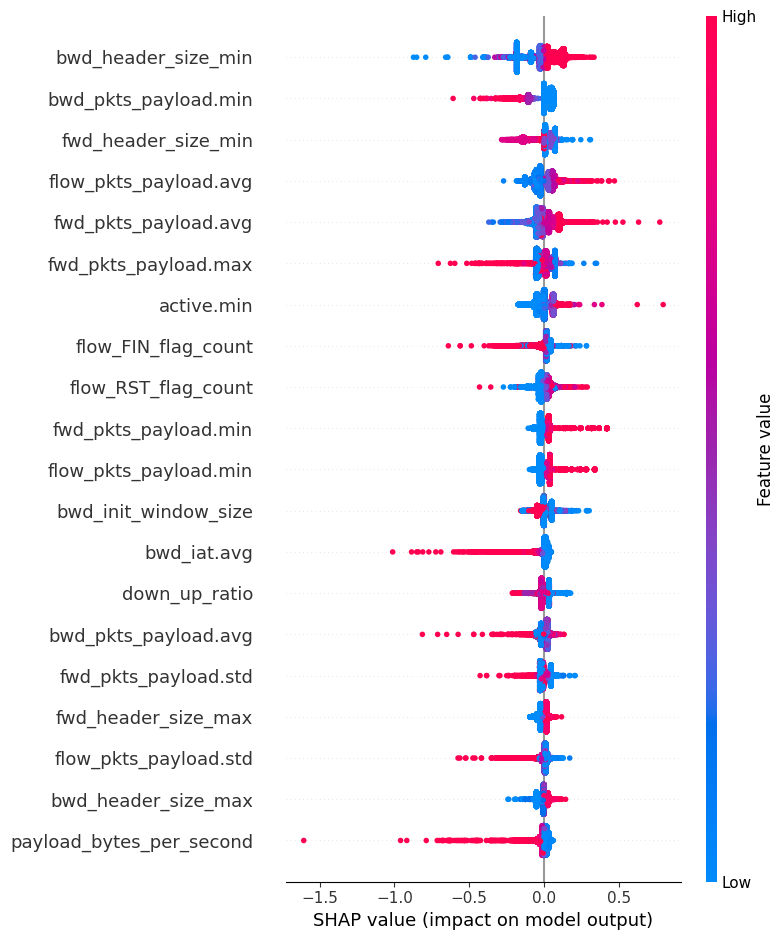

In [14]:
shap.summary_plot(exp, max_display=20)

In [15]:
feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
13,0.079019,bwd_header_size_min
30,0.055526,bwd_pkts_payload.min
10,0.053715,fwd_header_size_min
38,0.051753,flow_pkts_payload.avg
28,0.050679,fwd_pkts_payload.avg
26,0.038525,fwd_pkts_payload.max
66,0.036366,active.min
15,0.031301,flow_FIN_flag_count
17,0.030619,flow_RST_flag_count
25,0.027153,fwd_pkts_payload.min


In [16]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [17]:
%%time

# since I'm using only two tree it make sense to split the job on multiple cores
# so each forest will take two cores since it have two tree on it and then I will run along side other 6 forest in order to use all the cores
def get_score(features):
    X = X_res[features]
    y = ds.loc[y_res.index].Label
    cv_mean, cv_std, cv_time = cross_validation(X, y, y_res, 0, 131)
    return cv_mean, cv_std, len(features), cv_time

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    cv_time = []

    global scaler
    scaler.fit(ds[['fwd_iat.tot']])

    # making a warm up run otherwise the first one will be always slower than the others
    # only one features so that it can be as fast as possibile
    get_score(['fwd_iat.tot'])

    scaler.fit(ds[feature_above_zero])
    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])    
    cv_time.append(result[3])
    
    for i in range(1,len(feature_above_zero)):
        print(f"testing with {len(feature_above_zero[:-i])} features")
        scaler.fit(ds[feature_above_zero[:-i]])
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        cv_time.append(result[3])
        
    return scores, score_std, n_features, cv_time

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

execution time:  23.241100788116455
execution time:  22.382463455200195
execution time:  25.807324409484863
execution time:  23.21821165084839
execution time:  19.624114513397217
execution time:  24.78533387184143
execution time:  24.686002016067505
execution time:  24.864227771759033
execution time:  21.221213579177856
execution time:  23.874006271362305
execution time:  22.009422302246094
execution time:  25.723260402679443
execution time:  26.926077365875244
execution time:  26.014734983444214
execution time:  25.209208250045776
execution time:  25.354196071624756
execution time:  25.082455158233643
execution time:  25.845972299575806
execution time:  28.58922815322876
execution time:  27.891730070114136
testing with 77 features
execution time:  27.89479947090149
execution time:  33.709514141082764
execution time:  28.109262228012085
execution time:  15.065305233001709
execution time:  15.705268621444702
execution time:  16.183403730392456
execution time:  14.107132196426392
executi

In [18]:
load = True

if load:
    with open('mlp_data/feature_reduction_scores_dl.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)
else:
    with open('mlp_data/feature_reduction_scores_dl.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

<Axes: xlabel='n_features', ylabel='cv_time'>

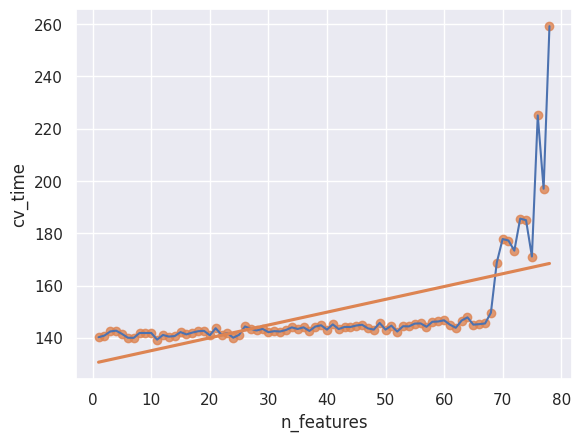

In [19]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

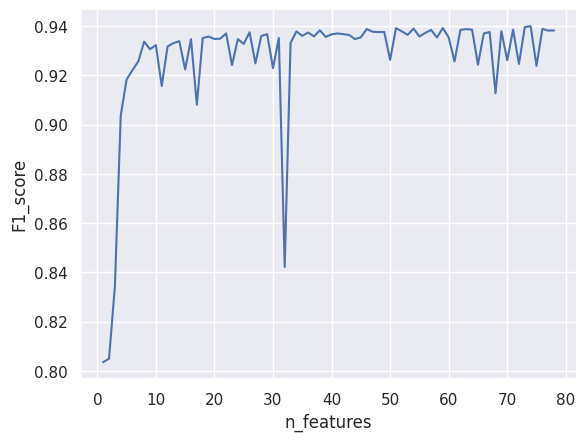

In [20]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

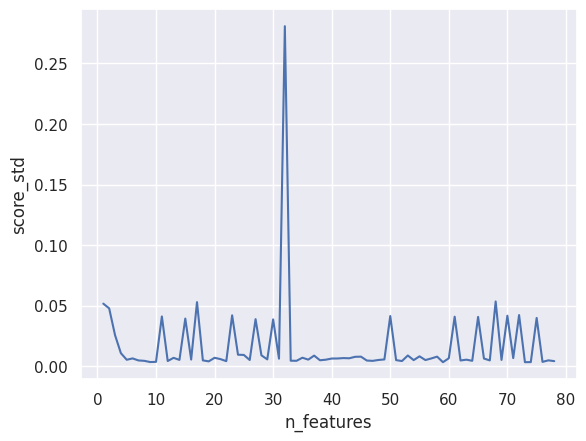

In [21]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [22]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
4,0.939958,0.003390,74,184.980103
5,0.939589,0.003332,73,185.586574
19,0.939206,0.003338,59,146.233027
27,0.939145,0.005032,51,144.639230
24,0.938984,0.005051,54,144.355181
...,...,...,...,...
74,0.903644,0.010782,4,142.717023
46,0.842232,0.280814,32,142.399025
75,0.834318,0.025727,3,142.417032
76,0.805016,0.047778,2,140.842739


In [ ]:
# add also training time
attack_f1 = []
attack_recall = []
attack_precision = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

# warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
warmup = True


def test_zero_day(attack, features, rus, rus_attack):
    print(f"training with {len(features)} features")
    global warmup
    epochs = 99
    
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
    X_attack = torch.from_numpy(X_attack.to_numpy().astype(np.float32)).to(device)
    y_attack = ds.loc[y_attack.index].Label
    
    cv_mean, cv_std, cv_time = cross_validation(X_res, ds.loc[y_res.index].Label, y_res, 0, epochs)
    
    if warmup:
        mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
        with torch.no_grad():
            mlp.eval()
            mlp(X_attack)
    
    start_fit = time.time()
    mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
    end_fit = time.time()
    
    with torch.no_grad():
        start_pred = time.time()
        mlp.eval()
        y_predicted = mlp(X_attack)
        end_pred = time.time()
        y_predicted = (y_predicted >= 0.5).squeeze().cpu()
    
    attack_f1.append(metrics.f1_score(y_attack, y_predicted))
    attack_recall.append(metrics.recall_score(y_attack, y_predicted))
    attack_precision.append(metrics.precision_score(y_attack, y_predicted))
    cv_score_avg.append(cv_mean)
    cv_score_std.append(cv_std)
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

    # at the very first iteration we change it to false
    warmup = False
    
def recursive_reduction(attack):
    global scaler
    # making a sample for having a 1:1 ration for positive and negative class
    # keep in mind that in the training I will have only three attacks, while for the test only one attack
    sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}
    
    # removing all the attack observations
    sampling_weights[attack] = 0
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    
    # adding the attack to the test dataset with the non attack traffic
    sampling_attack[attack] = 3279
    
    # making the dataset with only one attack
    rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)
    
    scaler.fit(ds[feature_above_zero])
    test_zero_day(attack, feature_above_zero, rus, rus_attack)

    for i in range(1,len(feature_above_zero)):
        scaler.fit(ds[feature_above_zero[:-i]])
        test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)

for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
training with 78 features
execution time:  9.812068223953247
execution time:  10.279394626617432
execution time:  9.449972867965698
execution time:  9.22813081741333
execution time:  9.186511754989624
execution time:  9.344129800796509
execution time:  10.221956253051758
execution time:  10.200540542602539
execution time:  9.845580577850342
execution time:  9.890907287597656
execution time:  10.541650772094727
execution time:  9.60523509979248


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 77 features
execution time:  8.387905836105347
execution time:  8.312114715576172
execution time:  8.554418802261353
execution time:  8.463443756103516
execution time:  8.897848129272461
execution time:  9.631818532943726
execution time:  8.78975224494934
execution time:  9.071309566497803


In [31]:
with open('mlp_data/zero_day_feature_reduction_scores_dl.pickle', 'wb') as handle:
    pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)